<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/CNN_marketing_emociones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Caso Práctico: CNN para Marketing
# Clasificador de Emociones en Imágenes

---

## 📋 Información del Módulo

**Asignatura:** Data Analytics: Data Science, Machine Learning e Inteligencia Artificial  
**Máster:** FP en Business Analytics e Inteligencia Artificial  
**Profesores:** Álvaro López Barberá
**Ejemplo Práctico:**  Deep Learning (CNN)

---

## 🎓 Objetivo

Desarrollar un clasificador de emociones basado en Redes Neuronales Convolucionales (CNN) para analizar imágenes y detectar expresiones faciales, con aplicación directa a casos de uso en marketing digital.

**Dataset:** FER-2013 (Facial Expression Recognition)  
**7 Emociones:** Enojado, Disgustado, Asustado, Feliz, Triste, Sorprendido, Neutral

---

### ⚙️ Configuración inicial

**Antes de empezar:**
1. Activa GPU: `Runtime → Change runtime type → GPU`
2. Ejecuta las celdas con `Shift + Enter`

---

## 📦 PASO 1: Instalación y Configuración Inicial

In [1]:
print("📦 Instalando dependencias...")

# Verificar versiones
import tensorflow as tf
print(f"✅ TensorFlow: {tf.__version__}")

# Imports necesarios
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n✅ Librerías cargadas correctamente")

📦 Instalando dependencias...
✅ TensorFlow: 2.19.0

✅ Librerías cargadas correctamente


---

## 📊 PASO 2: Carga y Exploración del Dataset FER-2013

### Descarga del dataset

**Ejecuta UNA de estas opciones:**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [ ]:
# OPCIÓN 1: Desde Kaggle (RECOMENDADO)
# Necesitas tu API token de Kaggle

# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d msambare/fer2013
# !unzip fer2013.zip

In [ ]:
# OPCIÓN 2: Desde URL directa (si está disponible)
# !wget https://www.dropbox.com/s/7r5g9u0k8h4g3qs/fer2013.csv

In [3]:
print("=" * 80)
print("PASO 2: CARGA DE DATOS - FER-2013 Dataset")
print("=" * 80)

# Clases de emociones
emotion_labels = {
    0: 'Enojado',
    1: 'Disgustado',
    2: 'Asustado',
    3: 'Feliz',
    4: 'Triste',
    5: 'Sorprendido',
    6: 'Neutral'
}

# Dimensiones
IMG_SIZE = 48
NUM_CLASSES = 7

print(f"\n📐 Características del dataset:")
print(f"   • Dimensión imágenes: {IMG_SIZE}x{IMG_SIZE} píxeles")
print(f"   • Canales: 1 (Escala de grises)")
print(f"   • Número de clases: {NUM_CLASSES}")
print(f"   • Clases: {list(emotion_labels.values())}")

PASO 2: CARGA DE DATOS - FER-2013 Dataset

📐 Características del dataset:
   • Dimensión imágenes: 48x48 píxeles
   • Canales: 1 (Escala de grises)
   • Número de clases: 7
   • Clases: ['Enojado', 'Disgustado', 'Asustado', 'Feliz', 'Triste', 'Sorprendido', 'Neutral']


### Función para cargar datos reales

In [4]:
def cargar_fer2013(csv_path):
    """
    Carga el dataset FER-2013 desde CSV

    Args:
        csv_path: Ruta al archivo fer2013.csv

    Returns:
        X: Array de imágenes (n_samples, 48, 48, 1)
        y: Array de etiquetas one-hot encoded (n_samples, 7)
    """
    print(f"📂 Cargando dataset desde: {csv_path}")
    df = pd.read_csv(csv_path)

    print(f"✅ Dataset cargado: {len(df)} imágenes")

    # Extraer píxeles y etiquetas
    pixels = df['pixels'].tolist()
    emotions = df['emotion'].values

    # Convertir strings de píxeles a arrays
    X = []
    for i, pixel_sequence in enumerate(pixels):
        if i % 5000 == 0:
            print(f"   Procesando imagen {i}/{len(pixels)}...")
        face = [int(pixel) for pixel in pixel_sequence.split()]
        face = np.array(face).reshape(48, 48, 1)
        X.append(face)

    X = np.array(X, dtype='float32')
    y = keras.utils.to_categorical(emotions, NUM_CLASSES)

    # Normalizar
    X = X / 255.0

    print(f"✅ Procesamiento completado")
    print(f"   • Shape X: {X.shape}")
    print(f"   • Shape y: {y.shape}")

    return X, y

---

## 🔧 PASO 3: Preparación de Datos

In [5]:
print("=" * 80)
print("PASO 3: PREPARACIÓN DE DATOS")
print("=" * 80)

# IMPORTANTE: Elige UNA de las dos opciones

# -----------------------------------------------------------------------------
# OPCIÓN A: DATOS SINTÉTICOS (SOLO PARA DEMO RÁPIDA)
# -----------------------------------------------------------------------------
print("\n⚠️  MODO DEMO: Usando datos sintéticos")
print("   Para usar datos reales, comenta esta sección y descomenta la siguiente")

np.random.seed(42)
tf.random.set_seed(42)

n_samples = 1400  # 200 por clase
X_all = np.random.rand(n_samples, IMG_SIZE, IMG_SIZE, 1).astype('float32')
y_all = np.random.randint(0, NUM_CLASSES, n_samples)
y_all = keras.utils.to_categorical(y_all, NUM_CLASSES)

# -----------------------------------------------------------------------------
# OPCIÓN B: DATOS REALES FER-2013 (USAR EN CLASE REAL)
# -----------------------------------------------------------------------------
# Descomentar estas líneas para usar datos reales:
# X_all, y_all = cargar_fer2013('fer2013.csv')  # Ajustar ruta si es necesario

PASO 3: PREPARACIÓN DE DATOS

⚠️  MODO DEMO: Usando datos sintéticos
   Para usar datos reales, comenta esta sección y descomenta la siguiente


In [6]:
# División de datos: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✅ División de datos completada:")
print(f"   • Entrenamiento: {X_train.shape[0]} imágenes ({X_train.shape[0]/len(X_all)*100:.1f}%)")
print(f"   • Validación: {X_val.shape[0]} imágenes ({X_val.shape[0]/len(X_all)*100:.1f}%)")
print(f"   • Test: {X_test.shape[0]} imágenes ({X_test.shape[0]/len(X_all)*100:.1f}%)")


✅ División de datos completada:
   • Entrenamiento: 980 imágenes (70.0%)
   • Validación: 210 imágenes (15.0%)
   • Test: 210 imágenes (15.0%)


In [7]:
# Visualizar distribución de clases
print(f"\n📊 Distribución de emociones en entrenamiento:")
train_distribution = np.argmax(y_train, axis=1)

for emotion_id, emotion_name in emotion_labels.items():
    count = np.sum(train_distribution == emotion_id)
    percentage = (count / len(train_distribution)) * 100
    bar = "█" * int(percentage / 5)
    print(f"   {emotion_name:12} | {bar:20} {count:4} ({percentage:5.1f}%)")


📊 Distribución de emociones en entrenamiento:
   Enojado      | ██                    142 ( 14.5%)
   Disgustado   | ██                    134 ( 13.7%)
   Asustado     | ██                    144 ( 14.7%)
   Feliz        | ██                    139 ( 14.2%)
   Triste       | ███                   151 ( 15.4%)
   Sorprendido  | ██                    123 ( 12.6%)
   Neutral      | ███                   147 ( 15.0%)


---

## 🔄 PASO 4: Data Augmentation

In [8]:
print("=" * 80)
print("PASO 4: DATA AUGMENTATION")
print("=" * 80)

print("\n🔄 Configurando técnicas de augmentación...")

# Generador con augmentación para entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Sin augmentación para validación
val_datagen = ImageDataGenerator()

print("✅ Augmentación configurada:")
print("   • Rotación: ±10°")
print("   • Desplazamiento: 10%")
print("   • Zoom: 10%")
print("   • Flip horizontal: Sí")
print("\n💡 Esto ayuda a que el modelo generalice mejor")

PASO 4: DATA AUGMENTATION

🔄 Configurando técnicas de augmentación...
✅ Augmentación configurada:
   • Rotación: ±10°
   • Desplazamiento: 10%
   • Zoom: 10%
   • Flip horizontal: Sí

💡 Esto ayuda a que el modelo generalice mejor


---

## 🏗️ PASO 5: Arquitectura CNN

In [9]:
print("=" * 80)
print("PASO 5: ARQUITECTURA CNN PERSONALIZADA")
print("=" * 80)

def crear_modelo_cnn_basico():
    """
    Arquitectura CNN para clasificación de emociones

    Estructura:
    - 3 bloques convolucionales (32, 64, 128 filtros)
    - BatchNormalization + MaxPooling + Dropout
    - 2 capas densas
    - Softmax para 7 clases
    """

    model = models.Sequential(name='EmotionCNN')

    # Bloque 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(IMG_SIZE, IMG_SIZE, 1),
                           padding='same', name='conv1'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Bloque 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                           padding='same', name='conv2'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Bloque 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu',
                           padding='same', name='conv3'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten y capas densas
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))

    # Salida
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

# Crear modelo
print("🏗️  Construyendo arquitectura...\n")
model = crear_modelo_cnn_basico()

# Mostrar resumen
model.summary()

# Parámetros
total_params = model.count_params()
print(f"\n📊 Total de parámetros: {total_params:,}")

PASO 5: ARQUITECTURA CNN PERSONALIZADA
🏗️  Construyendo arquitectura...



Model: "EmotionCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,308,295 (4.99 MB)

 Trainable params: 1,307,335 (4.99 MB)

 Non-trainable params: 960 (3.75 KB)


📊 Total de parámetros: 1,308,295


---

## ⚙️ PASO 6: Compilación del Modelo

In [10]:
print("=" * 80)
print("PASO 6: COMPILACIÓN DEL MODELO")
print("=" * 80)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\n✅ Modelo compilado:")
print("   • Optimizer: Adam (lr=0.001)")
print("   • Loss: Categorical Crossentropy")
print("   • Métricas: Accuracy, Precision, Recall")

PASO 6: COMPILACIÓN DEL MODELO

✅ Modelo compilado:
   • Optimizer: Adam (lr=0.001)
   • Loss: Categorical Crossentropy
   • Métricas: Accuracy, Precision, Recall


---

## 🎯 PASO 7: Callbacks

In [11]:
print("=" * 80)
print("PASO 7: CONFIGURACIÓN DE CALLBACKS")
print("=" * 80)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("\n✅ Callbacks configurados:")
print("   • Early Stopping: patience=5")
print("   • Reduce LR: factor=0.5, patience=3")

PASO 7: CONFIGURACIÓN DE CALLBACKS

✅ Callbacks configurados:
   • Early Stopping: patience=5
   • Reduce LR: factor=0.5, patience=3


---

## 🚀 PASO 8: Entrenamiento

In [12]:
print("=" * 80)
print("PASO 8: ENTRENAMIENTO DEL MODELO")
print("=" * 80)

EPOCHS = 25
BATCH_SIZE = 32

print(f"\n🚀 Configuración:")
print(f"   • Épocas: {EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Tiempo estimado: 2-3 minutos (con GPU)\n")

# Entrenar
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "=" * 80)
print("✅ ENTRENAMIENTO COMPLETADO!")
print("=" * 80)

PASO 8: ENTRENAMIENTO DEL MODELO

🚀 Configuración:
   • Épocas: 25
   • Batch size: 32
   • Tiempo estimado: 2-3 minutos (con GPU)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 339ms/step - accuracy: 0.1613 - loss: 2.9106 - precision: 0.1806 - recall: 0.0812 - val_accuracy: 0.1524 - val_loss: 2.6199 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.1576 - loss: 2.5069 - precision: 0.1495 - recall: 0.0481 - val_accuracy: 0.1381 - val_loss: 4.7056 - val_precision: 0.1381 - val_recall: 0.1381 - learning_rate: 0.0010
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.1558 - loss: 2.3686 - precision: 0.1556 - recall: 0.0340 - val_accuracy: 0.1381 - val_loss: 6.9498 - val_precision: 0.1381 - val_recall: 0.1381 - learning_rate: 0.0010
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.1321 - loss: 2.4234 - precision: 0.1229 - recall: 0.0215
Epoch 4: ReduceLROnPlateau reduci

---

## 📈 PASO 9: Visualización de Resultados

PASO 9: ANÁLISIS DE RESULTADOS


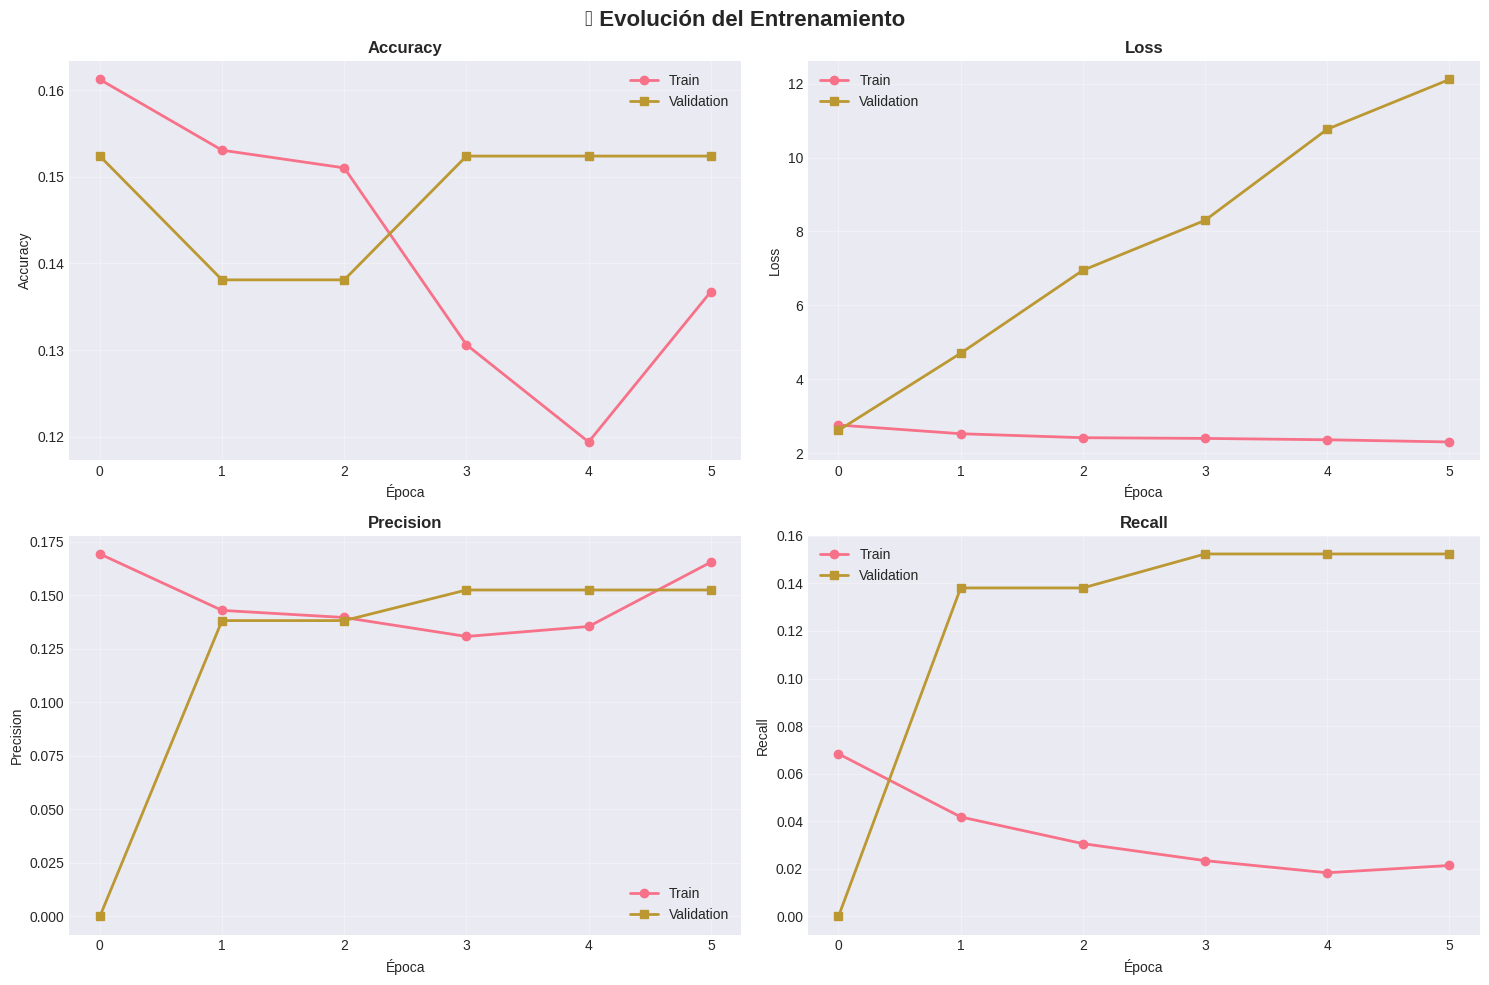

In [13]:
print("=" * 80)
print("PASO 9: ANÁLISIS DE RESULTADOS")
print("=" * 80)

def plot_training_history(history):
    """Visualiza el progreso del entrenamiento"""

    available_metrics = list(history.history.keys())
    precision_key = next((k for k in available_metrics if 'precision' in k.lower() and 'val' not in k), None)
    val_precision_key = next((k for k in available_metrics if 'precision' in k.lower() and 'val' in k), None)
    recall_key = next((k for k in available_metrics if 'recall' in k.lower() and 'val' not in k), None)
    val_recall_key = next((k for k in available_metrics if 'recall' in k.lower() and 'val' in k), None)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('📈 Evolución del Entrenamiento', fontsize=16, fontweight='bold')

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2, marker='o')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
    axes[0, 0].set_title('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2, marker='o')
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
    axes[0, 1].set_title('Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    if precision_key and val_precision_key:
        axes[1, 0].plot(history.history[precision_key], label='Train', linewidth=2, marker='o')
        axes[1, 0].plot(history.history[val_precision_key], label='Validation', linewidth=2, marker='s')
        axes[1, 0].set_title('Precision', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Precision no disponible',
                       ha='center', va='center', transform=axes[1, 0].transAxes)

    # Recall
    if recall_key and val_recall_key:
        axes[1, 1].plot(history.history[recall_key], label='Train', linewidth=2, marker='o')
        axes[1, 1].plot(history.history[val_recall_key], label='Validation', linewidth=2, marker='s')
        axes[1, 1].set_title('Recall', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Recall no disponible',
                       ha='center', va='center', transform=axes[1, 1].transAxes)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [14]:
    # Métricas finales

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"\n📊 Métricas Finales:")
print(f"   • Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   • Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   • Gap (Overfitting): {abs(train_acc - val_acc)*100:.2f}%")

print("\n⚠️ Si el training menos la validacion es mayor de un 10% posible overfitting detectado")



📊 Métricas Finales:
   • Training Accuracy: 0.1367 (13.67%)
   • Validation Accuracy: 0.1524 (15.24%)
   • Gap (Overfitting): 1.56%

⚠️ Si el training menos la validacion es mayor de un 10% posible overfitting detectado


---

## 🔍 PASO 10: Evaluación en Test Set

In [15]:
print("=" * 80)
print("PASO 10: EVALUACIÓN EN TEST SET")
print("=" * 80)

print("\n🔍 Evaluando en test (datos nunca vistos)...\n")

test_results = model.evaluate(X_test, y_test, verbose=0)
test_loss = test_results[0]
test_acc = test_results[1]
test_precision = test_results[2] if len(test_results) > 2 else 0
test_recall = test_results[3] if len(test_results) > 3 else 0

print(f"📊 Resultados en Test:")
print(f"   • Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   • Test Loss: {test_loss:.4f}")
print(f"   • Test Precision: {test_precision:.4f}")
print(f"   • Test Recall: {test_recall:.4f}")

if (test_precision + test_recall) > 0:
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"   • F1-Score: {f1_score:.4f}")
else:
    print(f"   • F1-Score: N/A")

PASO 10: EVALUACIÓN EN TEST SET

🔍 Evaluando en test (datos nunca vistos)...

📊 Resultados en Test:
   • Test Accuracy: 0.1571 (15.71%)
   • Test Loss: 2.5977
   • Test Precision: 0.0000
   • Test Recall: 0.0000
   • F1-Score: N/A


---

## 📊 PASO 11: Matriz de Confusión

PASO 11: MATRIZ DE CONFUSIÓN


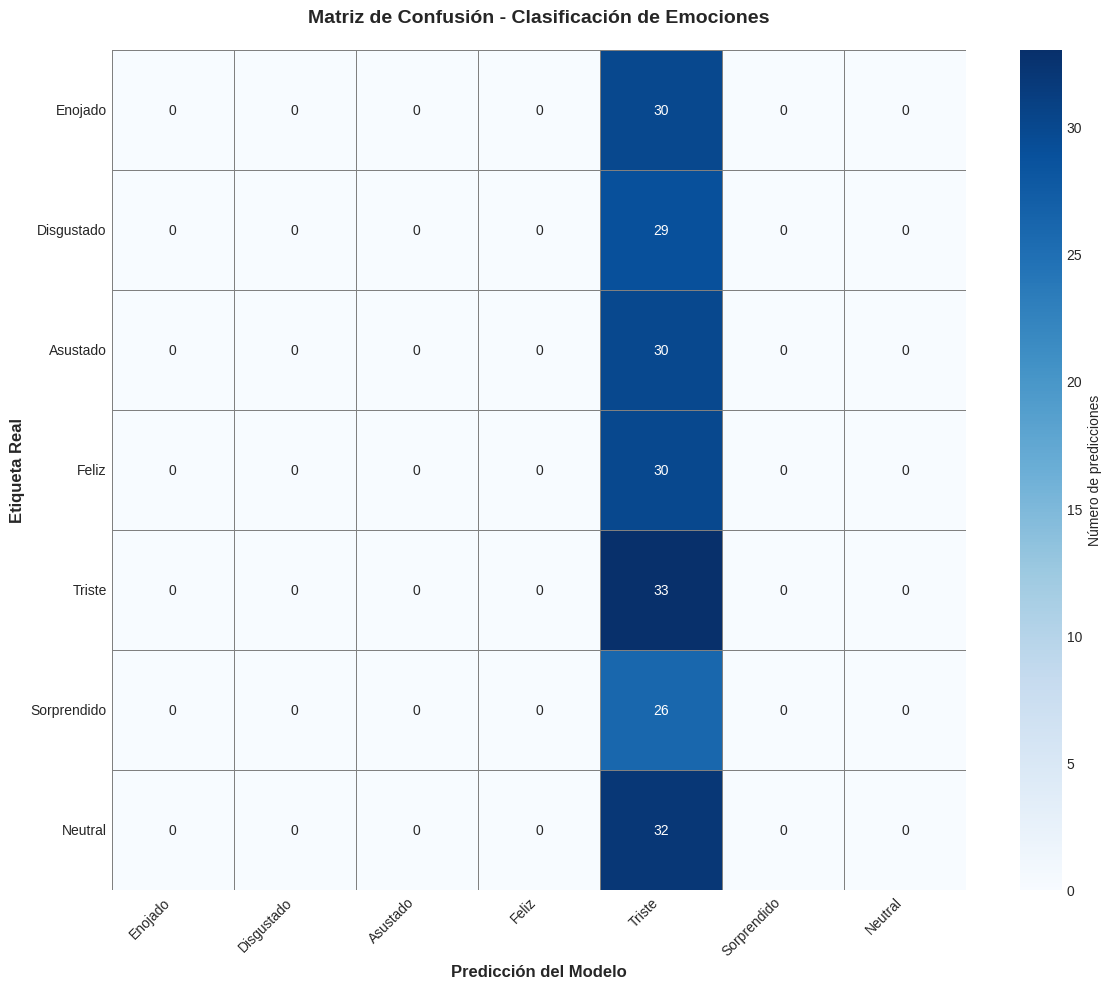


💡 Diagonal: predicciones correctas
   Fuera diagonal: confusiones del modelo


In [16]:
print("=" * 80)
print("PASO 11: MATRIZ DE CONFUSIÓN")
print("=" * 80)

# Generar predicciones
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular matriz
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()),
            cbar_kws={'label': 'Número de predicciones'},
            linewidths=0.5, linecolor='gray')
plt.title('Matriz de Confusión - Clasificación de Emociones',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Diagonal: predicciones correctas")
print("   Fuera diagonal: confusiones del modelo")

In [17]:
# Top confusiones
print("\n🔍 Top 3 confusiones más comunes:")
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
top_confusions = []

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm_copy[i, j] > 0:
            top_confusions.append((i, j, cm_copy[i, j]))

top_confusions.sort(key=lambda x: x[2], reverse=True)

for idx, (true_label, pred_label, count) in enumerate(top_confusions[:3], 1):
    print(f"   {idx}. {emotion_labels[true_label]} → {emotion_labels[pred_label]}: {count} veces")


🔍 Top 3 confusiones más comunes:
   1. Neutral → Triste: 32 veces
   2. Enojado → Triste: 30 veces
   3. Asustado → Triste: 30 veces


---

## 📋 PASO 12: Reporte de Clasificación

In [18]:
print("=" * 80)
print("PASO 12: REPORTE DE CLASIFICACIÓN")
print("=" * 80)

report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=list(emotion_labels.values()),
    digits=4
)

print("\n📋 Métricas detalladas por emoción:")
print("=" * 80)
print(report)
print("=" * 80)

PASO 12: REPORTE DE CLASIFICACIÓN

📋 Métricas detalladas por emoción:
              precision    recall  f1-score   support

     Enojado     0.0000    0.0000    0.0000        30
  Disgustado     0.0000    0.0000    0.0000        29
    Asustado     0.0000    0.0000    0.0000        30
       Feliz     0.0000    0.0000    0.0000        30
      Triste     0.1571    1.0000    0.2716        33
 Sorprendido     0.0000    0.0000    0.0000        26
     Neutral     0.0000    0.0000    0.0000        32

    accuracy                         0.1571       210
   macro avg     0.0224    0.1429    0.0388       210
weighted avg     0.0247    0.1571    0.0427       210



---

## 🎯 PASO 13: Aplicación a Marketing

### Casos de Uso en Marketing Digital

#### 1️⃣ Optimización de Creatividades Publicitarias
- Analizar qué emociones generan tus anuncios
- A/B testing basado en respuesta emocional
- ROI: Mejorar CTR y conversiones

#### 2️⃣ Segmentación de Audiencias
- Crear clusters por preferencias emocionales
- Personalizar mensajes por segmento
- ROI: Reducir CPA y aumentar engagement

#### 3️⃣ Análisis Competitivo
- Estudiar emociones de competidores
- Identificar oportunidades no explotadas
- ROI: Diferenciación de marca

#### 4️⃣ Testing de Producto
- Medir reacciones emocionales
- Focus groups automatizados
- ROI: Reducir riesgo de fracaso

#### 5️⃣ Contenido en RRSS
- Optimizar posts por engagement emocional
- Calendario balanceado de contenidos
- ROI: Aumentar alcance orgánico

In [19]:
print("=" * 80)
print("📸 EJEMPLO: Análisis de Creatividad Publicitaria")
print("=" * 80)

# Seleccionar muestra
np.random.seed(123)
muestra_idx = np.random.randint(0, len(X_test))
muestra_img = X_test[muestra_idx:muestra_idx+1]
muestra_true = emotion_labels[np.argmax(y_test[muestra_idx])]

# Predecir
prediccion = model.predict(muestra_img, verbose=0)[0]

print(f"\nAnálisis de Imagen #{muestra_idx}")
print(f"Emoción real: {muestra_true}")
print("\n📊 Distribución de probabilidades:")
print("-" * 60)

# Ordenar por probabilidad
emotion_probs = [(emotion_labels[i], prediccion[i]) for i in range(NUM_CLASSES)]
emotion_probs.sort(key=lambda x: x[1], reverse=True)

for emotion_name, prob in emotion_probs:
    prob_pct = prob * 100
    bar = "█" * int(prob_pct / 2)
    print(f"{emotion_name:12} | {bar:50} {prob_pct:5.1f}%")

emocion_dominante = emotion_probs[0][0]
confianza = emotion_probs[0][1] * 100

print(f"\n✨ Resultado:")
print(f"   • Emoción dominante: {emocion_dominante}")
print(f"   • Confianza: {confianza:.1f}%")

📸 EJEMPLO: Análisis de Creatividad Publicitaria

Análisis de Imagen #109
Emoción real: Feliz

📊 Distribución de probabilidades:
------------------------------------------------------------
Triste       | ████████████████                                    32.1%
Disgustado   | ███████████████                                     30.1%
Neutral      | █████████████                                       27.4%
Asustado     | █                                                    3.7%
Sorprendido  | █                                                    3.2%
Feliz        |                                                      1.8%
Enojado      |                                                      1.7%

✨ Resultado:
   • Emoción dominante: Triste
   • Confianza: 32.1%



💼 Recomendación de Marketing:
   Adecuada para RSC y storytelling emocional. Úsala con cuidado.


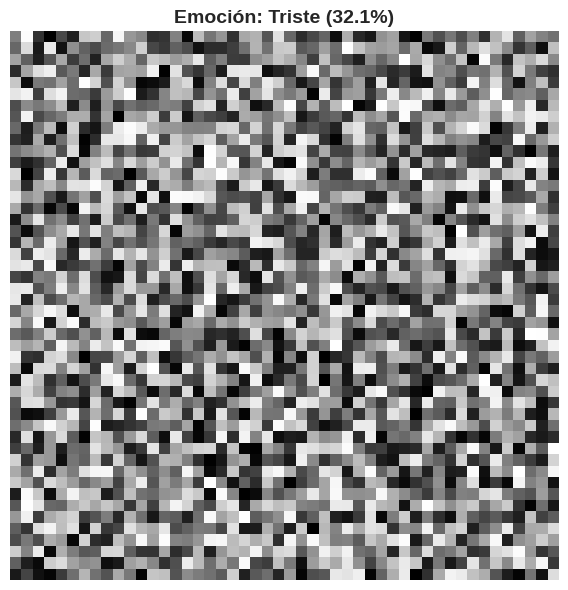

In [20]:
# Recomendaciones personalizadas
recomendaciones = {
    'Feliz': "Excelente para campañas de lifestyle y branding positivo. Úsala en landing pages.",
    'Neutral': "Ideal para comunicación corporativa y B2B. Transmite profesionalismo.",
    'Sorprendido': "Perfecta para lanzamientos y ofertas. Genera curiosidad y urgencia.",
    'Triste': "Adecuada para RSC y storytelling emocional. Úsala con cuidado.",
    'Enojado': "Útil para campañas disruptivas. Genera controversia y engagement.",
    'Asustado': "Apropiada para seguros y seguridad. Debe ir con la solución.",
    'Disgustado': "Efectiva para 'antes/después'. Contrasta con beneficios."
}

print(f"\n💼 Recomendación de Marketing:")
print(f"   {recomendaciones.get(emocion_dominante, 'Analiza contexto y audiencia.')}")

# Visualizar imagen
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(muestra_img[0, :, :, 0], cmap='gray')
ax.set_title(f'Emoción: {emocion_dominante} ({confianza:.1f}%)',
             fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

---

## 💾 PASO 14: Guardar el Modelo

In [ ]:
print("=" * 80)
print("PASO 14: GUARDAR MODELO")
print("=" * 80)

print("\n💾 Guardando modelo y pesos...")

# Guardar modelo completo
model.save('modelo_emociones_marketing.keras')
print("✅ Modelo: modelo_emociones_marketing.keras")

# Guardar pesos
model.save_weights('pesos_modelo.weights.h5')
print("✅ Pesos: pesos_modelo.weights.h5")

print("\n💡 Para cargar más adelante:")
print("   modelo = keras.models.load_model('modelo_emociones_marketing.keras')")

PASO 14: GUARDAR MODELO

💾 Guardando modelo y pesos...
✅ Modelo: modelo_emociones_marketing.keras
✅ Pesos: pesos_modelo.weights.h5

💡 Para cargar más adelante:
   modelo = keras.models.load_model('modelo_emociones_marketing.keras')


---

## 🎓 Resumen Final

In [ ]:
print("=" * 80)
print("🎓 RESUMEN Y APRENDIZAJES CLAVE")
print("=" * 80)

print("""
✅ Has aprendido:
   1. Arquitectura CNN para clasificación de imágenes
   2. Preprocesamiento y normalización de datos
   3. Data augmentation para generalización
   4. Callbacks para entrenamiento inteligente
   5. Evaluación completa con múltiples métricas
   6. Interpretación de matriz de confusión
   7. Aplicación práctica a casos de marketing
   8. Conexión entre métricas técnicas y KPIs

🚀 Próximos pasos:
   • Transfer Learning con modelos pre-entrenados
   • Interpretabilidad con Grad-CAM
   • Optimización de hiperparámetros
   • Despliegue como API REST
   • Integración con herramientas de marketing

💡 Ejercicios para casa:
   1. BÁSICO: Entrenar con dataset FER-2013 completo
   2. INTERMEDIO: Experimentar con arquitecturas diferentes
   3. AVANZADO: Implementar Transfer Learning
   4. PROYECTO: Dashboard para análisis de creatividades

📚 Recursos:
   • Dataset: kaggle.com/datasets/msambare/fer2013
   • Keras Docs: keras.io
   • Transfer Learning: keras.io/guides/transfer_learning/
""")

print("\n" + "=" * 80)
print("🎉 ¡CASO PRÁCTICO COMPLETADO!")
print("=" * 80)

print("""
📊 Estadísticas:
   • Pasos completados: 14/14 ✅
   • Modelo entrenado: ✅
   • Evaluación completada: ✅
   • Aplicación a marketing: ✅

❓ ¿Preguntas? ¿Dudas? ¿Ideas?
   Contacta con los profesores del módulo.

🎯 Recuerda: El objetivo no es solo entender CNN,
   sino aplicarlas para generar valor real.
""")

🎓 RESUMEN Y APRENDIZAJES CLAVE

✅ Has aprendido:
   1. Arquitectura CNN para clasificación de imágenes
   2. Preprocesamiento y normalización de datos
   3. Data augmentation para generalización
   4. Callbacks para entrenamiento inteligente
   5. Evaluación completa con múltiples métricas
   6. Interpretación de matriz de confusión
   7. Aplicación práctica a casos de marketing
   8. Conexión entre métricas técnicas y KPIs

🚀 Próximos pasos:
   • Transfer Learning con modelos pre-entrenados
   • Interpretabilidad con Grad-CAM
   • Optimización de hiperparámetros
   • Despliegue como API REST
   • Integración con herramientas de marketing

💡 Ejercicios para casa:
   1. BÁSICO: Entrenar con dataset FER-2013 completo
   2. INTERMEDIO: Experimentar con arquitecturas diferentes
   3. AVANZADO: Implementar Transfer Learning
   4. PROYECTO: Dashboard para análisis de creatividades

📚 Recursos:
   • Dataset: kaggle.com/datasets/msambare/fer2013
   • Keras Docs: keras.io
   • Transfer Learning